# check 2nd stg dataloader

In [19]:
import os

import numpy as np
import pandas as pd
from pandarallel import pandarallel
import matplotlib.pyplot as plt


In [20]:
import torch
from torch.utils.data import Dataset, DataLoader
import sys

sys.path.append("/kaggle/src/data/")
from dss_dataloader import DSSAddRolldiffDataset, DSSDataset

In [21]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

In [22]:
series_df = pd.read_parquet("/kaggle/working/_oof/exp008_meanstd_nonavepool/oof_df_secondstg.parquet")
key_df = series_df[["series_date_key", "series_date_key_str"]].drop_duplicates()
key_df["series_id"], key_df["date"] = (
    key_df["series_date_key_str"].str.split("_", 1).str
)
key_df = key_df.drop(columns=["series_date_key_str"], axis=1)

/tmp/ipykernel_14934/3571058063.py:4: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  key_df["series_date_key_str"].str.split("_", 1).str
/tmp/ipykernel_14934/3571058063.py:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  key_df["series_id"], key_df["date"] = (


In [23]:
import torch
import torch.nn as nn

ave_kernel_size = 301
maxpool_kernel_size = 11

ave_padding = int((ave_kernel_size - 1) / 2)
avg_pool = nn.AvgPool1d(
    kernel_size=ave_kernel_size,
    stride=1,
    padding=ave_padding,
)
maxpool_padding = int((maxpool_kernel_size - 1) / 2)
max_pool = nn.MaxPool1d(
    maxpool_kernel_size, stride=1, padding=maxpool_padding
)
def get_diff(x):
    shifted_x = torch.roll(x, 1, dims=-1)  # [batch, seq_len]
    invshifted_x = torch.roll(x, -1, dims=-1)
    diff_x = shifted_x - invshifted_x
    return diff_x

def get_diff_peak(x):
    peak = max_pool(x)
    peak_mask = (x == peak).float()
    peak = x * peak_mask
    return peak

In [40]:
class DSSEventDetDataset(Dataset):
    def __init__(
        self, key_df: pd.DataFrame, series_df: pd.DataFrame, mode: str = "train"
    ) -> None:
        self.key_df = key_df
        self.series_df = series_df
        self.mode = mode
        self.data_length = 17280

        maxpool_kernel_size = 61  # scoreが1.0の範囲
        maxpool_stride = 1
        # 入力サイズと出力サイズが一致するようにpaddingを調整
        self.max_pool = nn.MaxPool1d(
            kernel_size=maxpool_kernel_size,
            stride=maxpool_stride,
            padding=int((maxpool_kernel_size - 1) / 2),
        )
        large_max_pool_kernel_size = 361  # scoreが入る範囲
        self.large_max_pool = nn.MaxPool1d(
            kernel_size=large_max_pool_kernel_size,
            stride=1,
            padding=int((large_max_pool_kernel_size - 1) / 2),
        )
        # negativeが多くなりすぎてlogitsが小さくなってしまうのでかなり広めにとる
        ave_kernel_size = 361  # scoreが入る範囲
        ave_stride = 1
        ave_padding = int((ave_kernel_size - ave_stride) / 2)
        self.average_pool = nn.AvgPool1d(
            kernel_size=ave_kernel_size, stride=ave_stride, padding=ave_padding
        )
        print("dateset_initialized")

    def __len__(self) -> int:
        return len(self.key_df)

    def _padding_data_to_same_length(self, series_: np.ndarray) -> np.ndarray:
        if len(series_) < self.data_length:
            padding_length = self.data_length - len(series_)
            # TODO:計測できていないときのデータが0の場合は変更する必要がある
            padding_data = np.zeros(padding_length)
            series_data = np.concatenate([series_, padding_data])
        elif len(series_) > self.data_length:
            # print(f"[warning] data length is over.")
            series_data = series_[: self.data_length]
        else:
            series_data = series_
        return series_data

    def _get_input_data(self, series_df_: pd.DataFrame) -> np.ndarray:
        anglez = series_df_["anglez"].values
        enmo = series_df_["enmo"].values
        class_pred = series_df_["class_pred"].values
        anglez = self._padding_data_to_same_length(anglez)
        enmo = self._padding_data_to_same_length(enmo)
        class_pred = self._padding_data_to_same_length(class_pred)
        input_data = np.concatenate(
            [
                np.expand_dims(anglez, axis=0),
                np.expand_dims(enmo, axis=0),
                np.expand_dims(class_pred, axis=0),
            ]
        )  # [channel, data_length]
        input_data = torch.tensor(input_data, dtype=torch.float32)
        return input_data

    def _get_target_data(self, series_df_: pd.DataFrame) -> np.ndarray:
        target = series_df_["event"].values
        target = self._padding_data_to_same_length(target)
        target = np.expand_dims(target, axis=0)  # [channel=1, data_length]
        target = torch.tensor(target, dtype=torch.long)
        return target

    def _soft_label(self, target: torch.Tensor) -> torch.Tensor:
        target = target.float()
        target = target.unsqueeze(0)  # [channel=1, data_length]
        target = self.max_pool(target)
        positive_target = (target == 1).float()
        target = self.large_max_pool(target)
        for _ in range(3):
            target = self.average_pool(target)
        # target = self.average_pool(target)
        target = torch.clip(positive_target + target, 0, 1)
        return target

    def _get_event_target_data(self, series_df_: pd.DataFrame) -> torch.Tensor:
        event_onset = series_df_["event_onset"].values
        event_onset = self._padding_data_to_same_length(event_onset)
        event_onset = torch.tensor(event_onset, dtype=torch.float32)
        event_onset = self._soft_label(event_onset)

        event_wakeup = series_df_["event_wakeup"].values
        event_wakeup = self._padding_data_to_same_length(event_wakeup)
        event_wakeup = torch.tensor(event_wakeup, dtype=torch.float32)
        event_wakeup = self._soft_label(event_wakeup)
        event_target = torch.cat([event_onset, event_wakeup], dim=0)
        return event_target

    def __getitem__(self, idx):
        data_key = self.key_df["series_date_key"].iloc[idx]
        series_data = self.series_df[self.series_df["series_date_key"] == data_key]
        input = self._get_input_data(series_data)
        # series_date_keyと開始時刻のstepをdictにしておく
        input_info_dict = {
            "series_date_key": data_key,
            "start_step": series_data["step"].iloc[0].astype(np.int32),
            "end_step": series_data["step"].iloc[-1].astype(np.int32),
        }
        if self.mode == "test":
            return input, input_info_dict
        else:
            event_target = self._get_event_target_data(series_data)
            return input, event_target, input_info_dict

dateset_initialized
5369
0


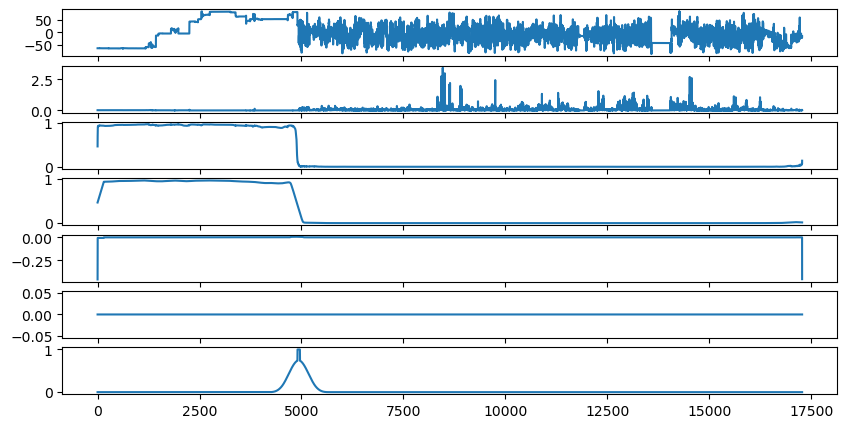

target_onset sum tensor(0.) target_wakeup sum tensor(436.8065)
CPU times: user 5.85 s, sys: 452 ms, total: 6.3 s
Wall time: 1.33 s


In [41]:
%%time

dataset = DSSEventDetDataset(key_df, series_df, mode="valid")
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)
print(len(dataset))
show_idx = 1
for idx, (input, target,_) in enumerate(dataloader):
    print(idx)
    # if idx < show_idx:
    #     continue
    if idx > show_idx:
        break
    class_pred = input[0, 2, :]
    avepooled = avg_pool(class_pred.unsqueeze(dim=0))  # [batch, seq_len]
    diff_avepooled = get_diff(avepooled)
    peak_values = get_diff_peak(diff_avepooled)  # [batch, seq_len]
    plt.figure(figsize=(10, 5))
    plt.subplot(7, 1, 1)
    plt.plot(input[0, 0, :].numpy(), label="anglez")
    plt.subplot(7, 1, 2)
    plt.plot(input[0, 1, :].numpy(), label="enmo")
    plt.subplot(7, 1, 3)
    plt.plot(input[0, 2, :].numpy(), label="class_pred")
    plt.subplot(7, 1, 4)
    plt.plot(avepooled[0,:].numpy(), label="avepooled")
    plt.subplot(7, 1, 5)
    plt.plot(diff_avepooled[0,:].numpy(), label="diff_avepooled")
    plt.subplot(7, 1, 6)
    plt.plot(target[0, 0, :].numpy(), label="target_onset")
    plt.subplot(7, 1, 7)
    plt.plot(target[0, 1, :].numpy(), label="target_wakeup")
    plt.show()
    print("target_onset sum", target[0, 0, :].sum(), "target_wakeup sum", target[0, 1, :].sum())
    break